# Demo of Ch5. Sequential Learning
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## Import packages
----
- `keras`:
    - `preprocessing.*`: text cleanup, text pre-processing, and text sequences tokenization before import into models
    - `models.*`, `embeddings.*`, `layers.*`, and `optimizers.*`: For loading related components layers to constructing recurrent neural network (including both LSTM, GRU or the simplest version RNN)

In [1]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import Adadelta
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import os
import re
import requests
import codecs

from io import BytesIO
from zipfile import ZipFile

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss

from matplotlib import pyplot as plt
from mlfund.plot import PlotMetric
%matplotlib inline

Using TensorFlow backend.


## Load Dataset
----
The **SMS Spam Collection Data Set** is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged acording being ham (legitimate) or spam.

For more information, see: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [2]:
dataset_dir = os.path.join('data', 'demo5')
dataset_path = os.path.join('data', 'demo5', 'SMSSpamCollection')

def download_dataset():
    r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip')
    if r.status_code == 200:
        f_zip = ZipFile(BytesIO(r.content))

        dataset_raw_content = f_zip.read('SMSSpamCollection')
        with open(dataset_path, 'wb') as f_dataset:
            f_dataset.write(b'label\tcontent\n')
            f_dataset.write(dataset_raw_content)
    else:
        assert('Error for downloading SMS Spam Collection Dataset')
        

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
if not os.path.exists(dataset_path):
    download_dataset()
    
df = pd.read_csv(dataset_path, sep='\t')
display(df)

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## 5.4. Applications

### Demo 5.4.1. Tokenization
---
The demo here shows how to:
- Use regular expression for the roughly text cleanup, and
- Use `keras.preprocessing.text.text_to_word_sequence` for sequence tokenization.

In [3]:
X_str = [ re.sub(r'(\<[a-zA-Z\s]+(\/)?\>)|[\'\"\\]', ' ', text_raw).lower() for text_raw in df['content'] ]
X_str = [ text_to_word_sequence(x_str) for x_str in X_str ]

for i in range(0, 20):
    print('[\'%s\' ...]' % '\', \''.join(X_str[i][0:10]))

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n' ...]
['ok', 'lar', 'joking', 'wif', 'u', 'oni' ...]
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa' ...]
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then' ...]
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he' ...]
['freemsg', 'hey', 'there', 'darling', 'it', 's', 'been', '3', 'week', 's' ...]
['even', 'my', 'brother', 'is', 'not', 'like', 'to', 'speak', 'with', 'me' ...]
['as', 'per', 'your', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam' ...]
['winner', 'as', 'a', 'valued', 'network', 'customer', 'you', 'have', 'been', 'selected' ...]
['had', 'your', 'mobile', '11', 'months', 'or', 'more', 'u', 'r', 'entitled' ...]
['i', 'm', 'gonna', 'be', 'home', 'soon', 'and', 'i', 'don', 't' ...]
['six', 'chances', 'to', 'win', 'cash', 'from', '100', 'to', '20', '000' ...]
['urgent', 'you', 'have', 'won', 'a', '1', 'week', 'free', 

The steps here encoded the string-based label into numeric-based labels.

In [4]:
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

y = label_encoder.transform(df['label'])

display( [ (idx, label) for idx, label in enumerate(label_encoder.classes_) ] )

[(0, 'ham'), (1, 'spam')]

### Demo 5.4.2. Encode the Top-K words in Dataset
----
The demo here shows how to use `keras.preprocessing.text.Tokenizer` to encode each word according to word occurrences by an index.

In [5]:
MAX_NUM_DICT_WORDS     = 2000
MAX_SEQUENCE_LENGTH    = 50
WORD_EMBED_DIMENSION   = 50

tokenizer = Tokenizer(oov_token='UNK', num_words=MAX_NUM_DICT_WORDS + 1)
tokenizer.fit_on_texts(X_str)

for key in sorted(tokenizer.index_word)[:50]:
    print('%d\t => %s' % (key, tokenizer.index_word[key]))

1	 => UNK
2	 => i
3	 => to
4	 => you
5	 => a
6	 => the
7	 => u
8	 => and
9	 => in
10	 => is
11	 => me
12	 => my
13	 => it
14	 => for
15	 => your
16	 => of
17	 => call
18	 => have
19	 => that
20	 => s
21	 => on
22	 => 2
23	 => now
24	 => are
25	 => can
26	 => so
27	 => t
28	 => but
29	 => not
30	 => m
31	 => or
32	 => do
33	 => at
34	 => we
35	 => ur
36	 => get
37	 => will
38	 => if
39	 => be
40	 => with
41	 => just
42	 => no
43	 => this
44	 => 4
45	 => gt
46	 => lt
47	 => how
48	 => up
49	 => when
50	 => ok


To convert the tokenized word sequences into fix-sized index-based sequences:
- Use `Tokenizer.texts_to_sequences` for converting string list into index list, and
- Use `keras.preprocessing.sequence.pad_sequences` for padding the sequences into fix-length index list

In [6]:
X = tokenizer.texts_to_sequences(X_str)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

for i in range(0, 20):
    print('%s' % (X[i]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   54  464    1  825  742  648   71    9 1307   94  129  336
 1308  151    1 1309   63   62    1  141]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   50  337 1474  465    7 1911]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   52  482    9   22    5  783  885    3  182 1912 1086
  649 1913    1  260    1   75 1912    3 1914    3  338  482  550  942
   77  391   27  121   20  392    1   20]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   7 248 155  26 380   1   7 121 159  61 155]
[   0    0    0    0    0    0 

### Demo 5.4.3. Convert each Words by External Word2Vec Data
----
The demo here shows how to convert the words by external **GloVe** representations.

The GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

For more information, see: https://nlp.stanford.edu/projects/glove/

**Notice:**
- For this demo, you're required to manually download the `glove.6B.zip` from the project page mentioned above (822MB)
- After downloaded, place the `glove.6B.50d.txt` under `data/demo5`
- The word dictionary would then be built based on the tokenizer constructed above

In [7]:
word2vec_path = os.path.join('data', 'demo5', 'glove.6B.50d.txt')

if not os.path.exists(word2vec_path):
    raise FileNotFoundError('Please follow the instructions mentioned above to get glove.6B.50d.txt')

embed_mat = np.zeros( (MAX_NUM_DICT_WORDS + 1, WORD_EMBED_DIMENSION ) )
with codecs.open(word2vec_path, 'r', 'utf-8') as f:
    for line in f.readlines():
        tokens = line.rstrip(' \r\n').split(' ')
        
        word_key    = tokens[0]
        word_vector = [float(i) for i in tokens[1:]]
        
        if word_key in tokenizer.word_index and tokenizer.word_index[word_key] < MAX_NUM_DICT_WORDS + 1:
            embed_mat[ tokenizer.word_index[word_key], : ] = word_vector

**Notice:**
You may also discovered that some of word might not appeared in the pre-trained dictionary:

In [8]:
for idx, vec in enumerate(embed_mat):
    if np.sum(vec) == 0 and idx != 0:
        print('Not found: %d \t[%s]' % (idx, tokenizer.index_word[idx]))

Not found: 1 	[UNK]
Not found: 192 	[150p]
Not found: 323 	[£1]
Not found: 365 	[£1000]
Not found: 376 	[150ppm]
Not found: 385 	[aight]
Not found: 403 	[thanx]
Not found: 512 	[£100]
Not found: 577 	[£5000]
Not found: 596 	[8007]
Not found: 603 	[£2000]
Not found: 614 	[chikku]
Not found: 617 	[£500]
Not found: 635 	[86688]
Not found: 681 	[12hrs]
Not found: 684 	[msgs]
Not found: 705 	[knw]
Not found: 711 	[pobox]
Not found: 718 	[08000930705]
Not found: 725 	[ni8]
Not found: 728 	[frnd]
Not found: 730 	[boytoy]
Not found: 735 	[mobileupd8]
Not found: 754 	[mrng]
Not found: 758 	[oredi]
Not found: 765 	[suite342]
Not found: 766 	[2lands]
Not found: 767 	[08000839402]
Not found: 772 	[£3]
Not found: 783 	[wkly]
Not found: 784 	[freemsg]
Not found: 791 	[frnds]
Not found: 811 	[£250]
Not found: 816 	[savamob]
Not found: 847 	[87066]
Not found: 851 	[bslvyl]
Not found: 855 	[txts]
Not found: 865 	[£2]
Not found: 873 	[£350]
Not found: 875 	[mayb]
Not found: 901 	[askd]
Not found: 907 	[

The word vectors of the first 5 words:

In [9]:
for i in range(2,7):
    print('%s => %s\n' % (tokenizer.index_word[i], embed_mat[i]))

i => [ 1.1891e-01  1.5255e-01 -8.2073e-02 -7.4144e-01  7.5917e-01 -4.8328e-01
 -3.1009e-01  5.1476e-01 -9.8708e-01  6.1757e-04 -1.5043e-01  8.3770e-01
 -1.0797e+00 -5.1460e-01  1.3188e+00  6.2007e-01  1.3779e-01  4.7108e-01
 -7.2874e-02 -7.2675e-01 -7.4116e-01  7.5263e-01  8.8180e-01  2.9561e-01
  1.3548e+00 -2.5701e+00 -1.3523e+00  4.5880e-01  1.0068e+00 -1.1856e+00
  3.4737e+00  7.7898e-01 -7.2929e-01  2.5102e-01 -2.6156e-01 -3.4684e-01
  5.5841e-01  7.5098e-01  4.9830e-01 -2.6823e-01 -2.7443e-03 -1.8298e-02
 -2.8096e-01  5.5318e-01  3.7706e-02  1.8555e-01 -1.5025e-01 -5.7512e-01
 -2.6671e-01  9.2121e-01]

to => [ 0.68047  -0.039263  0.30186  -0.17792   0.42962   0.032246 -0.41376
  0.13228  -0.29847  -0.085253  0.17118   0.22419  -0.10046  -0.43653
  0.33418   0.67846   0.057204 -0.34448  -0.42785  -0.43275   0.55963
  0.10032   0.18677  -0.26854   0.037334 -2.0932    0.22171  -0.39868
  0.20912  -0.55725   3.8826    0.47466  -0.95658  -0.37788   0.20869
 -0.32752   0.12751   0.0883

### Demo 5.4.4. Learning with LSTM
----
The demo here shows how to train a LSTM model based on pre-processed text-sequences, then conduct the classification problem for recognizing spam and legitimate messages.

In [10]:
def create_lstm():
    model = Sequential()
    
    model.add(Embedding(MAX_NUM_DICT_WORDS + 1, WORD_EMBED_DIMENSION, weights=[embed_mat], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(LSTM(64))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model

In [11]:
model = create_lstm()
model.summary()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train, epochs=10, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            100050    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 146,387
Trainable params: 46,337
Non-trainable params: 100,050
_________________________________________________________________

Error rate = 0.013


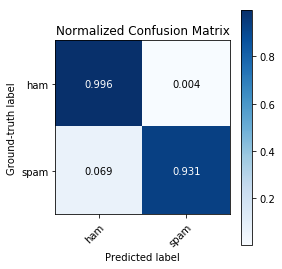

In [12]:
y_test_predict = model.predict(X_test)

idx_true = y_test_predict > 0.9
y_test_predict [ idx_true ] = 1
y_test_predict [ ~idx_true ] = 0
y_test_predict = y_test_predict.astype(int)

# Error rate
err_01loss = zero_one_loss(y_test, y_test_predict)
print('Error rate = %2.3f' % err_01loss)

# Confusion matrix of prediction
plot_conf_mat = PlotMetric(figsize=(4, 4))
plot_conf_mat.set_labels(label_encoder.classes_.tolist())
plot_conf_mat.confusion_matrix(y_test, y_test_predict, True)